# Tutorial 4 - Pioneer
This tutorial models a potential design for a WEC used to provide power to instruments in the [Pioneer Central Surface Mooring System](https://oceanobservatories.org/site/cp01cnsm/) within the National Science Foundation Ocean Observatories Initiative [Coastal Pioneer Array](https://oceanobservatories.org/array/coastal-pioneer-array/).
This system has instrumentation to measure various meteorological, surface, near-surface, and seabed phenomena on the Continental Shelf-Slope and transmit back to shore.

Unlike previous tutorials, this tutorial does not include an outer optimization loop.
Instead, the focus here is on effectively modeling an optimization problem for the control of a unique WEC archetype with a pitch resonator PTO with several co-dependent components.
This is completely setup in Part 1, and includes:

* Expanding the control state vector
* Custom PTO physics
* Modeling non-hydrodynamic degrees of freedom

This tutorial is divided into three parts.
The first sets up the problem including the points above.
The second and third show results using a regular and irregular wave, respectively.

1. [Model setup](#1.-Model-setup)
2. [Regular wave results](#2.-Regular-wave-results)
3. [Irregular wave](#3.-Irregular-wave)


<p><img src=https://oceanobservatories.org/wp-content/uploads/2015/09/Central-Surface-Mooring-Array-01-1.png alt="Diagram of the Pioneer device" width="200"></p>

In [31]:
import capytaine as cpy
from capytaine.io.meshio import load_from_meshio
import autograd.numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
import xarray as xr
from math import comb

import wecopttool as wot

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

## 1. Model setup

### 1.1 Waves
We start with setting up the different waves we want to model, as this will inform what to select for our frequency range, which we need throughout the rest of the problem setup. 
We will consider two waves: a regular wave and an irregular wave, both with typical characteristics of the deployment site.
The regular wave is roughly at 0.35 Hz, the known pitch resonance frequency of the buoy.
The irregular wave has a peak period of 5 seconds, matching that of the deployment site.

Please refer to Tutorial 3 for information about selecting the number of realizations.
For the purpose of the tutorial, the number of realizations has been set to 2 to reduce runtime.

The procedure for determining an appropriate frequency array for irregular wave conditions is detailed at the end of this tutorial.

In [32]:
fend = 1.875
nfreq_irreg = 150
f1_irreg = fend / nfreq_irreg

f1_reg = .325/2
nfreq_reg = 12

In [33]:
# regular
amplitude = 0.15
wavefreq = 0.325
waves_regular = wot.waves.regular_wave(f1_reg, nfreq_reg, wavefreq, amplitude)

# irregular
Hs = 1.5
Tp = 5 
nrealizations = 2

fp = 1/Tp
spectrum = lambda f: wot.waves.pierson_moskowitz_spectrum(f, fp, Hs)
efth = wot.waves.omnidirectional_spectrum(f1_irreg, nfreq_irreg, spectrum, "Pierson-Moskowitz")
waves_irregular = wot.waves.long_crested_wave(efth, nrealizations=nrealizations)

We plot the wave elevation spectra to check if the chosen frequency array covers the main excitation frequency, converges to zero for larger frequencies and can capture multiple harmonics which are required for nonlinear dynamics, since the states are multiplied with each other.

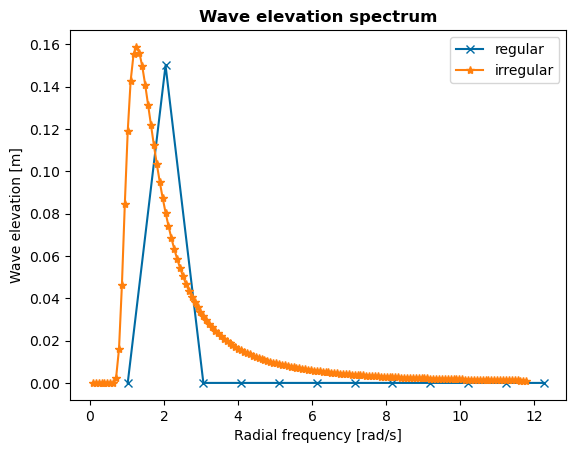

In [34]:
#TODO: highlight the harmonics if wave freq and Tp with other markers+colors
fig, ax = plt.subplots()
np.abs(waves_regular).plot(marker = 'x', label="regular")
np.abs(waves_irregular.sel(realization=0)).plot(marker = '*', label="irregular")
ax.set_title('Wave elevation spectrum', fontweight='bold')
plt.legend()

### 1.2 Basic properties

#### Geometry
To get the required hydrodynamic coefficients of the Pioneer design, we only need to be concerned with creating a mesh of the buoy geometry.
The buoy has the same general shape as the WaveBot used in Tutorial 1, so we will use the build-in `geom.WaveBot` object and change the dimensions to simplify the mesh creation process.

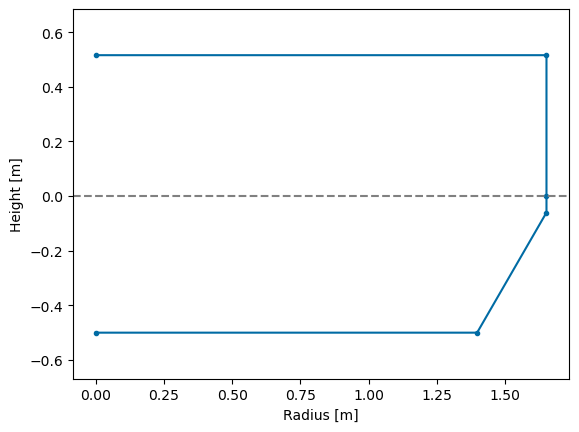

In [35]:
in2m = 0.0254 # inch -> meter conversion factor
draft = 0.5 # meters
freeboard = 40. * in2m - draft
hull_geom = wot.geom.WaveBot(r1=130./2 * in2m,
                             r2=110./2 * in2m, 
                             h1=22.679 * in2m,
                             h2=17.321 * in2m,
                             scale_factor=1,
                             freeboard=freeboard)
mesh = hull_geom.mesh(mesh_size_factor=0.3)
_ = hull_geom.plot_cross_section()

#### Design properties
The Pioneer team has developed initial specifications for a full-sized WEC design that fits within the buoy dimensions and operating at resonance.
There are several components that we need to capture in the PTO model:

* **Buoy**: As mentioned, this has the same basic geometric parameters as the WaveBot used in Tutorial 1.
Since we're only modeling the pitch degree of freedom, we only need the pitch moment of inertia and not the mass of the buoy.
* **Flywheel**: The flywheel is contained and dimensioned to fit on top of the buoy.
It rotates in pitch independently of the buoy, but is linked to the buoy through two parallel connections: the torsional spring and the generator.
Since the flywheel is protected from wave loading by the buoy, it is **not** subject to hydrostatics or hydrodynamics.
* **Spring**: The magnetic torsional spring provides positive stiffness to the flywheel.
It has a linear displacement up to 45 degrees, at which point it "wraps around" and the stiffness begins decreasing.
For simplicity, we will model the spring as strictly linear.
The spring is connected to a gearbox which makes the position of the spring (and therefore, the generator shaft) different from the relative position of the flywheel and buoy. 

A rendering of the Pioneer WEC model is shown here with the buoy pitch in red and the flywheel pitch in green:
<p><img src=https://live.staticflickr.com/65535/53025745404_2e75c89894_k.jpg alt="Diagram of the Pioneer device" width="500"></p>

In [36]:
buoy_props = {
    'CG': 0.298, # m
    'MOI': 7484., # kg-m^2
    'Resonance frequency': 0.35, # Hz
}

# flywheel properties at example resonance
flywheel_properties = {
    'coulomb_friction': 4.5, # N*m
    'viscous_friction': 0.02, # N*ms/rad
    'motor_gear_ratio': 0.118,
    'MOI': 22.32, # kg*m^2
}

spring_properties = {
    'stiffness': 835.36, # N*m/rad
    'gear_ratio': 0.334,
    'Max torque': 750, # N-m
    'Max displacement': np.deg2rad(45.0), # rad
}

# PTO properties
pto_properties = {
    'gear_ratio': 1.0,
    'torque_constant': 0.164,
    'winding_resistance': 0.0718,
    'winding_inductance': 0.0,
    'drivetrain_inertia': 0.0,
    'drivetrain_friction': 0.0,
    'drivetrain_stiffness': 0.0,
}

#### Pitch resonator
This system uses a unique PTO system, where the generator velocity is dependent on the relative pitching rotation of the buoy and the flywheel.
The system can be modeled as a coupled spring-mass-damper system, with the generator represented as $B_{PTO}$.
The spring-mass-damper system and equivalent circuit model are shown below.
Note that all of these values are rotational and are drawn here linearly for simplicity. 

<p><img src=https://live.staticflickr.com/65535/53025028262_1a4ba2d5ce_z.jpg alt="Pioneer model as a spring-mass-damper system" width="500"> <img src=https://live.staticflickr.com/65535/53025140497_29c5b9d601_z.jpg alt="Pioneer model as a spring-mass-damper system" width="180"></p>

This corresponds to the following dynamics equations:

(1)

$$ [J_{buoy} + J(\omega))] \ddot{\theta}_{buoy} = T_{hydro} - K_{hydro}\theta_{buoy} - B(\omega)\dot{\theta}_{buoy} - K_{spring}(\theta_{buoy} - \theta_{flywheel})/N^2 - (B_{PTO} + B_{fric})(\dot{\theta}_{buoy} - \dot{\theta}_{flywheel}) $$

(2)

$$ J_{flywheel} \ddot{\theta}_{flywheel} = K_{spring}(\theta_{buoy} - \theta_{flywheel})/N^2 + (B_{PTO} + B_{fric})(\dot{\theta}_{buoy} - \dot{\theta}_{flywheel}) $$

We will explore how to capture these dynamics in WecOptTool in the following sections.

#### Hydrodynamics and hydrostatics
As mentioned above, the `FloatingBody` object in Capytaine only needs to model the buoy, since no other components are being excited by the waves. 
We will not use the BEM results since we are using an empirical impedance model, but the BEM problem is still solved here for comparison purposes.

[13:08:45] WARNING  The rotation dof Pitch has been initialized around the origin of the domain (0, 0, 0).

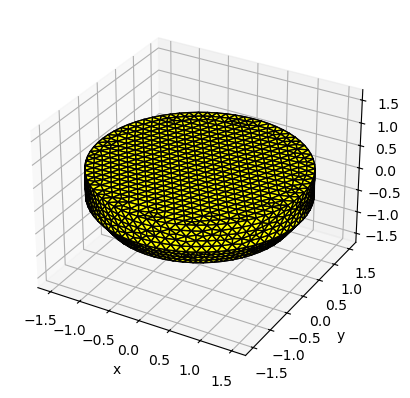

In [37]:
mesh_obj = load_from_meshio(mesh, 'Pioneer')
lid_mesh = mesh_obj.generate_lid(-4e-2)

pnr_fb = cpy.FloatingBody(mesh=mesh_obj, lid_mesh=lid_mesh, name="WaveBot")
pnr_fb.add_rotation_dof(name='Pitch')
pnr_fb.center_of_mass = np.array([0., 0., buoy_props['CG']])
pnr_fb.rotation_center = pnr_fb.center_of_mass
ndof = pnr_fb.nb_dofs
pnr_fb.show_matplotlib()

pnr_fb.inertia_matrix = xr.DataArray(data=np.asarray(([[buoy_props['MOI']]])),
                            dims=['influenced_dof', 'radiating_dof'],
                            coords={'influenced_dof': list(pnr_fb.dofs),
                                    'radiating_dof': list(pnr_fb.dofs)},
                            name="inertia_matrix")

In [38]:
rho = 1025. # kg/m^3
freq_reg = wot.frequency(f1_reg, nfreq_reg, False) # False -> no zero frequency
bem_data_reg = wot.run_bem(pnr_fb, freq_reg)
omega_reg = bem_data_reg.omega.values

freq_irreg = wot.frequency(f1_irreg, nfreq_irreg, False) # False -> no zero frequency
bem_data_irreg = wot.run_bem(pnr_fb, freq_irreg)
omega_irreg = bem_data_irreg.omega.values

pnr_fb.keep_immersed_part()
k_buoy = pnr_fb.compute_hydrostatic_stiffness(rho=rho).values.squeeze()
k_spring = spring_properties['Max torque'] / spring_properties['Max displacement']
print(f'Hydrostatic stiffness from Capytaine: {k_buoy} N-m/rad')
print('Hydrostatic stiffness from experiment: 37204 N-m/rad')

[13:08:46] WARNING  center_of_mass already defined as [0.    0.    0.298].

           WARNING  rotation_center already defined as [0.    0.    0.298].

           WARNING  FloatingBody has no hydrostatic_stiffness field. Capytaine will auto-populate the hydrostatic  
                    stiffness based on the provided mesh.

The resolution of the mesh might be insufficient for omega ranging from 9.189 to 12.252.
This warning appears when the largest panel of this mesh has radius > wavelength/8.


           WARNING  Mesh resolution for 8 problems:                                                                
                    The resolution of the mesh might be insufficient for omega ranging from 9.189 to 12.252.       
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[13:09:00] WARNING  center_of_mass already defined as [0.    0.    0.298].

           WARNING  rotation_center already defined as [0.    0.    0.298].

           WARNING  FloatingBody has no hydrostatic_stiffness field. Capytaine will auto-populate the hydrostatic  
                    stiffness based on the provided mesh.

The resolution of the mesh might be insufficient for omega ranging from 8.482 to 11.781.
This warning appears when the largest panel of this mesh has radius > wavelength/8.


           WARNING  Mesh resolution for 86 problems:                                                               
                    The resolution of the mesh might be insufficient for omega ranging from 8.482 to 11.781.       
                    This warning appears when the largest panel of this mesh has radius > wavelength/8.

c:\Users\jtgrasb\AppData\Local\anaconda3\envs\wot_dev\Lib\site-packages\rich\live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Hydrostatic stiffness from Capytaine: 38550.43817553295 N-m/rad
Hydrostatic stiffness from experiment: 37204 N-m/rad


Although the system has yet to be deployed as a WEC, the Coastal Pioneer Array itself has been collecting data from multiple locations. From the collected data, an empirical impedance model and excitation force spectrum has been developed. This empirical dataset can replace the BEM dataset in order to model the WEC dynamics. Here, we load in the data and convert it into two DataArrays for the intrinsic impedance and the excitation coefficients, respectively. We then interpolate from the empirical data to match the intended frequency array.

In [39]:
# load in the empirical data
datafile = 'data/pioneer_empirical_data.nc'
empirical_data = xr.load_dataset(datafile)

omega_data = empirical_data.omega
exc_coeff_data = empirical_data.exc_coeff_data_real + 1j*empirical_data.exc_coeff_data_imag
Zi_data = empirical_data.Zi_data_real + 1j*empirical_data.Zi_data_imag
Zi_stiffness = empirical_data.Zi_stiffness

# here extrapolation for impedance and padding with zeros for the excitation
exc_coeff_intrp_reg = exc_coeff_data.interp(omega = omega_reg, method='linear', kwargs={"fill_value": 0})
Zi_intrp_reg = Zi_data.interp(omega = omega_reg, kwargs={"fill_value": "extrapolate"})

exc_coeff_intrp_irreg = exc_coeff_data.interp(omega = omega_irreg, method='linear', kwargs={"fill_value": 0})
Zi_intrp_irreg = Zi_data.interp(omega = omega_irreg, kwargs={"fill_value": "extrapolate"})

For validation purposes, we compare the empirical impedance and excitation to the results from BEM.

In [ ]:
hd = wot.add_linear_friction(bem_data_irreg, friction = None) 
# we're not actually adding friction, but need the datavariables in hd 
hd = wot.check_radiation_damping(hd)

Zi_bem = wot.hydrodynamic_impedance(hd)
fig, axes = wot.utilities.plot_bode_impedance(Zi_bem,'WaveBot Intrinsic Impedance')
fig, axes = wot.utilities.plot_bode_impedance(Zi_data,'WaveBot Intrinsic Impedance',fig_axes=[fig, axes])
fig, axes = wot.utilities.plot_bode_impedance(Zi_intrp_irreg,'WaveBot Intrinsic Impedance',fig_axes=[fig, axes])
fig.set_size_inches(6, 4)
fig.legend(('BEM Data','Empirical Data','Interpolated Empirical Data'), bbox_to_anchor=(.58, .46))

In [ ]:
fig, ax = plt.subplots(2, 1,tight_layout=True, sharex=True, figsize=(6, 4))

ax[0].semilogx(freq_irreg, np.real(bem_data_irreg['diffraction_force'][:,0,0]+bem_data_irreg['Froude_Krylov_force'][:,0,0]), label='BEM Data')
ax[0].semilogx(omega_data/(2*np.pi), np.real(exc_coeff_data[:,0,0]), label='Empirical Data')
ax[0].semilogx(omega_irreg/(2*np.pi), np.real(exc_coeff_intrp_irreg[:,0,0]), label='Interpolated Empirical Data')
ax[0].grid(True, which = 'both')
ax[1].semilogx(freq_irreg, np.imag(bem_data_irreg['diffraction_force'][:,0,0]+bem_data_irreg['Froude_Krylov_force'][:,0,0]), label='BEM Data')
ax[1].semilogx(omega_data/(2*np.pi), np.imag(exc_coeff_data[:,0,0]), label='Empirical Data')
ax[1].semilogx(omega_irreg/(2*np.pi), np.imag(exc_coeff_intrp_irreg[:,0,0]), label='Interpolated Empirical Data')
ax[1].grid(True, which = 'both')

ax[0].set_ylabel('Re[Excitation]')
ax[1].set_ylabel('Im[Excitation]')
ax[1].set_xlabel('Frequency (Hz)')
ax[0].legend()

### 1.3 PTO
The generator shaft velocity is the difference between the buoy velocity and the flywheel velocity.
Because the velocity PTO depends not only on the hydrodynamic states (`x_wec`, buoy pitch) but also on an additional non-hydrodynamic state (flywheel pitch), we cannot use the `PTO` module we have used in previous tutorials.
We will make two adjustments to our previous modeling approach model to accurately model the PTO:

1. Adjust the `x_opt` vector to include the flywheel motion
2. Manually define the PTO dynamics and energy equations in place on the `PTO` module

#### Capturing flywheel motions
In previous tutorials, all the relevant WEC dynamics have been captured in the `x_wec` vector.
However, `x_wec` assumes all the degrees of freedom are excited by waves, which is not the case for the flywheel in the Pioneer model.
Instead, we will include the flywheel dynamics in the `x_opt` vector.

The `x_opt` vector has previously only been used to model the PTO force.
However, there is no limit to what `x_opt` can include; it can theoretically include anything that is needed to model the PTO control.
Here, we will append the Fourier coefficients of the flywheel's position to `x_opt`.
The first part of `x_opt` will continue to be used for the PTO force (i.e. Fourier coefficients of the force time-series for an unstructured controller). 

Note in the code further down that `x_opt` will be spliced as either `x_opt[:nstate_pto]` to exclude the flywheel position states, or `x_opt[nstate_pto:]` to exclude the PTO force states.
Remember, `x_opt` can be defined arbitrarily, and specific meanings to the states are given elsewhere in the model.

In [ ]:
nstate_pto = 2 * nfreq_reg # PTO forces
nstate_fw = 2 * nfreq_reg  # Flywheel positions
nstate_opt = nstate_pto + nstate_fw

#### Manually defining PTO equations
Instead of calling the `PTO` module, we will manually define the dynamics and energy equations needed for WecOptTool to calculate electrical power, our quantity of interest for this optimization problem.
These equations are also needed for the additional forces and constraints defined later on.

##### Relative motion
Here we define functions for the relative motion of the buoy and flywheel, derived from `x_wec` and `x_opt` respectively.

In [ ]:
def x_rel(wec, x_wec, x_opt):
    pos_wec = wec.vec_to_dofmat(x_wec)
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    return pos_wec - pos_fw

def rel_position(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_rel = x_rel(wec, x_wec, x_opt)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, pos_rel)

def rel_velocity(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_rel = x_rel(wec, x_wec, x_opt)
    vel_rel = np.dot(wec.derivative_mat, pos_rel)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, vel_rel)

##### Unstructured controller
This is nearly identical to the `wot.pto.controller_unstructured` function, except `x_opt` is spliced to only include the first part, since we are also including the flywheel positions in the second part of `x_opt`.

In [ ]:
def force_from_generator(wec, x_wec, x_opt, waves=None, nsubsteps=1):
    f_fd = np.reshape(x_opt[:nstate_pto], (-1, ndof), order='F')
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    torque = np.dot(time_matrix, f_fd) * flywheel_properties['motor_gear_ratio']
    return torque

##### PTO Impedance
The PTO impedance is defined using the same 2-port impedance model as in previous tutorials. This pto model does not account for the relative velocity, generator force, etc. so it will not be used to define the PTO in the final system. Instead, it is used to create the PTO transfer matrix which is used in the calculation of electrical power.

In [ ]:
drivetrain_impedance = (1j*omega_reg*pto_properties['drivetrain_inertia'] +
                    pto_properties['drivetrain_friction'] +
                    1/(1j*omega_reg)*pto_properties['drivetrain_stiffness'])

winding_impedance = pto_properties['winding_resistance'] + 1j*omega_reg*pto_properties['winding_inductance']

pto_impedance_11 = -1* pto_properties['gear_ratio']**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * pto_properties['torque_constant'] * pto_properties['gear_ratio']
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega_reg.shape)
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega_reg.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                        [pto_impedance_21, pto_impedance_22]])

pto = wot.pto.PTO(ndof, kinematics=[1], controller=None, impedance=pto_impedance, loss=None, names=None)


##### Power and Energy
Finally, we will wrap the relative motions, force, and impedance functions together to calculate average electrical power. This is again very close to what is found in the PTO module, except `rel_velocity` replaces `wot.pto.PTO.velocity` and `force_from_generator` replaces `wot.pto.PTO.force`.

In [ ]:
def mechanical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    force_td = force_from_generator(wec, x_wec, x_opt, waves, nsubsteps)
    vel_td = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return vel_td * force_td

def electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    q1_td = rel_velocity(wec, x_wec, x_opt, waves)
    e1_td = force_from_generator(wec, x_wec, x_opt, waves)
    q1 = wot.complex_to_real(wec.td_to_fd(q1_td, False))
    e1 = wot.complex_to_real(wec.td_to_fd(e1_td, False))
    vars_1 = np.hstack([q1, e1])
    vars_1_flat = wec.dofmat_to_vec(vars_1)
    vars_2_flat = np.dot(pto._transfer_mat, vars_1_flat)
    vars_2 = wot.vec_to_dofmat(vars_2_flat, 2)
    q2 = vars_2[:, 0]
    e2 = vars_2[:, 1]
    time_mat = wec.time_mat_nsubsteps(nsubsteps)
    q2_td = np.dot(time_mat, q2)
    e2_td = np.dot(time_mat, e2)
    return q2_td * e2_td

def energy(wec, x_wec, x_opt, waves, nsubsteps=1):
    power_td = electrical_power(wec, x_wec, x_opt, waves, nsubsteps)
    return np.sum(power_td) * wec.dt/nsubsteps

def average_electrical_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    e = energy(wec, x_wec, x_opt, waves, nsubsteps)
    return e / wec.tf

### 1.4 Constraints
The Pioneer model only contains one constraint based on the generator being used:

* **Peak torque** - The motor should avoid torques greater than 120 N-m. 
This is the same basic constraint as `const_f_pto` from Tutorial 1, except we use our `force_from_generator` definition instead of `wot.pto.PTO.force_on_wec`.

In [ ]:
max_generator_torque = 25.8 # N*m
nsubsteps_constraints = 5

def constraint_max_generator_torque(wec, x_wec, x_opt, waves, nsubsteps=nsubsteps_constraints):
    torque = force_from_generator(wec, x_wec, x_opt, waves, nsubsteps)
    return max_generator_torque - np.abs(torque.flatten())

### 1.5 Additional forces
Here we add in the forces acting on the bodies other than those generated from wave loading.

* **Flywheel friction** - The dissipative torque from the generator and components. This is defined as a nonlinear force using both Coulomb friction (dependent on the PTO direction) and the viscous friction (dependent on the PTO speed).

* **Magnetic spring** - The restoring torque caused by the torsional spring between the buoy and flywheel. Note a spring gear ratio is included in this equation, as a gearbox is connected in series with the spring. The position of the spring is the relative position of the flywheel and buoy scaled by the reciprocal of gear ratio squared. There are 2 options here: 

   * Linear spring:  
        * Used for simplified modeling purposes 
        * The WecOptTool optimization problem is first solved with the linear spring, the results from which are used as initialization for the nonlinear spring case

   * Nonlinear spring: 
        * Represents the real spring design developed for this application 
        * The resultant torque has a periodic "tilted sine" profile with respect to the spring angle. This design emulates a linear spring until about 135 degrees in either direction before repreating the torque profile.
        * Final result uses the nonlinear spring

In [ ]:
def force_from_friction(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    rel_vel = rel_velocity(wec, x_wec, x_opt, waves, nsubsteps) * flywheel_properties['motor_gear_ratio']
    fric =  -1*(
        np.tanh(rel_vel)*flywheel_properties['coulomb_friction'] +
        rel_vel*flywheel_properties['viscous_friction']
    ) * flywheel_properties['motor_gear_ratio']
    return fric

def linear_spring(pos):
    return spring_properties['gear_ratio'] * -spring_properties['stiffness'] * pos

def force_from_lin_spring(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
        pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) * spring_properties['gear_ratio']
        return linear_spring(pos)

def nonlinear_spring(pos):
    # 135 deg nonlinear spring
    spring_eq_pos_td = pos - np.pi
    n = 12
    slope = 1/(2**(2*n))*comb(2*n,n)
    scale = 1/slope
    new_pos = 0
    for ind in range(n):
        k = ind+1
        coeffs = comb(2*n, n-k)/(k*(2**(2*n-1)))
        new_pos = new_pos - coeffs*np.sin(k*spring_eq_pos_td)
    return spring_properties['gear_ratio'] * -spring_properties['stiffness'] * scale * new_pos

def force_from_nl_spring(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    pos = rel_position(wec, x_wec, x_opt, waves, nsubsteps) * spring_properties['gear_ratio']
    return nonlinear_spring(pos)

spring_angle_rad = np.arange(-2*np.pi, 2*np.pi, np.pi/200)

plt.figure()
plt.plot(spring_angle_rad,linear_spring(spring_angle_rad), label = 'Linear spring')
plt.plot(spring_angle_rad,nonlinear_spring(spring_angle_rad), label = 'Nonlinear spring',ls='--')
plt.xlabel('Spring displacement (rad)')
plt.ylabel('Spring torque [N-m]')
plt.legend()

### 1.6 Flywheel residual equation
To make sure the flywheel dynamics are properly modeled in the pseudo-spectral method, we will introduce an equality constraint consisting of Newton's 2nd law of motion on the flywheel in residual form:

$$ r(x) = I \alpha - \tau = 0 $$

Note that there are 2 residual equations below, one using the linear spring and another using the nonlinear spring. 
Both are included because we solve the problem using the linear spring to given initial conditions for the nonlinear spring solve. 
More information is included in Section 2.1.
This is the same structure as the residual for the WEC dynamics described in the [WecOptTool theory documentation](https://sandialabs.github.io/WecOptTool/theory.html).
Also compare this equation to the 2nd dynamics equation listed [above](#pitch-resonator).

This is required because the equations of motion described by `x_wec` only capture the buoy pitch degree of freedom.
This equation provides a second equality constraint to capture the flywheel pitch degree of freedom, resulting in two coupled dynamic equations.

In [ ]:
def flywheel_inertia(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    acc_fw = np.dot(wec.derivative2_mat, pos_fw)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    acc_fw = np.dot(time_matrix, acc_fw)
    return flywheel_properties['MOI'] * acc_fw

def flywheel_residual_lin_spring(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    resid = (
    flywheel_inertia(wec, x_wec, x_opt, waves, nsubsteps) +
    force_from_lin_spring(wec, x_wec, x_opt, waves, nsubsteps) +
    force_from_friction(wec, x_wec, x_opt, waves, nsubsteps) +
    force_from_generator(wec, x_wec, x_opt, waves, nsubsteps)
    )
    return resid.flatten()

def flywheel_residual_nl_spring(wec, x_wec, x_opt, waves = None, nsubsteps = 1):
    resid = (
    flywheel_inertia(wec, x_wec, x_opt, waves, nsubsteps) +
    force_from_nl_spring(wec, x_wec, x_opt, waves, nsubsteps) +
    force_from_friction(wec, x_wec, x_opt, waves, nsubsteps) +
    force_from_generator(wec, x_wec, x_opt, waves, nsubsteps)
    )
    return resid.flatten()

We now create the additional forces and constaints that will be passed to the `WEC` object. Note that `f_add` only pertains to the buoy since that is the only degree of freedom included in the BEM data; our flywheel residual equation handles these forces for the flywheel in the opposite direction. Just like for the flywheel residual equations, there are 2 different sets of added forces and constraints, one including the linear spring and another including the nonlinear spring.

In [ ]:
f_add_lin_spring = {
    'Generator': force_from_generator,
    'Friction': force_from_friction,
    'Spring': force_from_lin_spring,
}

f_add_nl_spring = {
    'Generator': force_from_generator,
    'Friction': force_from_friction,
    'Spring': force_from_nl_spring,
}

constraints_lin_spring = [
    {'type': 'eq', 'fun': flywheel_residual_lin_spring}, # flywheel EoM
    {'type': 'ineq', 'fun': constraint_max_generator_torque},
]

constraints_nl_spring = [
    {'type': 'eq', 'fun': flywheel_residual_nl_spring}, # flywheel EoM
    {'type': 'ineq', 'fun': constraint_max_generator_torque},
]

### 1.7 WEC object
We now have all the information required to create our `WEC` object. The `from_impedance` method is used, because we are using our empirical impedance data. We create one `WEC` object for each of the linear and nonlinear springs.

In [ ]:
wec_lin = wot.WEC.from_impedance(freq_reg, Zi_intrp_reg,exc_coeff_intrp_reg,
                            Zi_stiffness,
                            f_add_lin_spring,
                            constraints_lin_spring)

wec_nl = wot.WEC.from_impedance(freq_reg, Zi_intrp_reg,exc_coeff_intrp_reg,
                            Zi_stiffness,
                            f_add_nl_spring,
                            constraints_nl_spring)

## 2. Regular wave results

### 2.1 Solve
As in previous tutorials, we will optimize for electrical power absorption. First, we solve the optimization problem using the linear spring case, then we use those results to initialize the nonlinear spring case. This process helps the optimizer (which can have difficulty with highly nonlinear force profiles) converge quicker and more consistently.

In [ ]:
obj_fun = average_electrical_power
results = wec_lin.solve(
    waves_regular,
    obj_fun,
    nstate_opt,
    scale_x_wec=1e0,
    scale_x_opt=np.concatenate((np.array([1e-1])*np.ones(nstate_pto), 1 * np.ones(nstate_fw))),
    scale_obj=1e-2,
)
x_wec_0, x_opt_0 = wec_lin.decompose_state(results[0].x)

results = wec_nl.solve(
    waves_regular,
    obj_fun,
    nstate_opt,
    x_wec_0=x_wec_0, # initialize with result from linear spring case
    x_opt_0=x_opt_0, # initialize with result from linear spring case
    scale_x_wec=1e0,
    scale_x_opt=np.concatenate((np.array([1e-1])*np.ones(nstate_pto), 1 * np.ones(nstate_fw))),
    scale_obj=1e-2,
)
print(f'Optimal average power: {results[0].fun:.2f} W')

### 2.2 Post-process and plot
Again, since we are not actually using the `PTO` module in the optimization problem, post-processing using `wot.pto.PTO.post_process` is not an option here, so we have to manually post-process the outputs related to the PTO and flywheel.
This is pretty intuitive using the functions we created earlier.
The outputs related to the buoy can still be derived directly from `wot.wec.post_process`.

In [ ]:
nsubsteps = 5
wec_fdom, wec_tdom = wec_nl.post_process(wec_nl, results, waves_regular, nsubsteps=nsubsteps)

# Manually post-process PTO and flywheel outputs
x_wec, x_opt = wot.decompose_state(results[0].x, 1, nfreq_reg)
fw_pos = np.dot(wec_nl.time_mat_nsubsteps(nsubsteps), x_opt[nstate_pto:])
pto_pos = rel_position(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_vel = rel_velocity(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_force = force_from_generator(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_force_fd = wec_nl.td_to_fd(pto_force[::nsubsteps])
spring_force = force_from_nl_spring(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_mech_power = mechanical_power(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_elec_power = electrical_power(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
avg_mech_power = np.mean(pto_mech_power)
avg_elec_power = np.mean(pto_elec_power)

Some observations about the optimized Pioneer model:

 * The flywheel and buoy match frequency, but are out of phase due to the forcing from the spring and motor applied to both bodies.
 * The gearing in series with the torsional spring (which reduces the effective spring stiffness) significantly amplifies the rotation of the flywheel despite the buoy only pitching modestly.
 The gear ratio of 3 was selected by the Pioneer team to keep the system in resonance considering the spring stiffness, moment of inertia of the flywheel, and the resonance frequency of the buoy.
 Try increasing the gear ratio or flywheel moment of inertia—this will actually reduce the power generated since it will bring the effective stiffness of the flywheel out of resonance, causing less motion relative to the buoy.
 * The nonlinear spring torque is sinusoidal because it stays within the linear region of operation.
 * The mechanical and electrical power outputs are similar, since our impedance model has only a small amount of resistance and no inductance.
 * The buoy's pitch amplitude is larger than expected for this device and is likely due to underestimation of the radiation damping by the BEM. 

In [ ]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(12, 12))
t = wec_tdom[0].time.values

# Positions
ax[0].plot(t, fw_pos*180/np.pi, label='Flywheel', c='k')
ax[0].plot(t, pto_pos*180/np.pi, label='PTO', c='k', ls='--')
ax[0].set_title('Pitch Displacements')
ax[0].set_ylabel('Position [deg]')
ax[0].legend()

ax0 = ax[0].twinx()
ax0.tick_params(axis='y', labelcolor='b')
(wec_tdom[0].pos*180/np.pi).plot(hue='influenced_dof', label='Buoy', ax=ax0, c='b')
ax0.set_ylabel('Buoy pos. [deg]', color='b')
ax0.set_title('')

# Torques
ax[1].plot(t, pto_force, c='k')
ax[1].plot([t[0], t[-1]], [max_generator_torque, max_generator_torque], 'k--')
ax[1].plot([t[0], t[-1]], [-1*max_generator_torque, -1*max_generator_torque], 'k--')
ax[1].set_ylabel('PTO torque [N-m]')
ax[1].set_title('Torque')

ax1 = ax[1].twinx()
ax1.tick_params(axis='y', labelcolor='b')
# when using an impedance model, the excitation force cannot be split up into Froude-Krylov and diffraction
wec_tdom[0]['force'].sel(type='excitation').plot(ax=ax1, c='b') 
ax1.set_ylabel('Excitation torque [N-m]', color='b')
ax1.set_title('Torque')

# PTO Velocity
ax[2].plot(t, pto_vel)
ax[2].set_title('PTO Velocity')
ax[2].set_ylabel('Velocity [deg/s]')

# Spring
ax[3].plot(t, spring_force, c='k')
ax[3].set_title('Nonlinear Spring Torque')
ax[3].set_ylabel('Torque [N-m]')

ax3 = ax[3].twinx()
ax3.tick_params(axis='y', labelcolor='b')
ax3.plot(t, pto_pos, c='b')
ax3.set_ylabel('PTO pos. [deg]', color='b')
ax3.set_title('')

# Power
ax[4].plot(t, pto_mech_power, label='Mech. power ($\\bar{P}_{mech}$: ' + f'{avg_mech_power:.1f} W)')
ax[4].plot(t, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')
ax[4].set_title('Power Output')
ax[4].set_ylabel('Power [W]')
ax[4].legend()
ax[4].set_xlabel('Time [s]')

for axi in ax:
    axi.grid()
    axi.label_outer()
    axi.autoscale(axis='x', tight=True)

### 2.3 Sankey Diagram
We use a Sankey diagram to visualize the average power flow from waves to electricity.
The left end shows the theoretically possible optimal excitation.
In order to reach this upper bound of excitation, the WEC pitch velocity would need to be in phase with the pitch excitation force (or, in this case, the radiated power is equal the amount of absorbed mechanical power).
In practice, this will usually imply putting electrical power into the system (something we want to avoid!!!).

With co-design, we are instead tapping the unused potential while limiting PTO losses and radiated power.

In [ ]:
Zi = Zi_intrp_reg
Rad_res = np.real(Zi.squeeze())

Fex = wec_fdom[0].force.sel(type=['excitation'])
Vel = wec_fdom[0].vel

P_max_absorbable = (np.abs(Fex)**2/(8*Rad_res) ).squeeze().sum('omega').item() # after Falnes Eq. 6.10
P_opt_excitation = 2*P_max_absorbable # after Falnes Eq. 6.10
P_radiated = ((1/2)*(Rad_res * np.abs(Vel)**2 ).squeeze().sum('omega').item()) # after Falnes Eq. 6.4
P_excited= (1/4)*(Fex*np.conjugate(Vel) + np.conjugate(Fex)*Vel ).squeeze().sum('omega').item() # after Falnes Eq. 6.3

power_flows = {'Optimal Excitation' : -2* (np.real(P_max_absorbable)),    
            'Radiated': -1*(np.real(P_radiated)), 
            'Actual Excitation': -1*(np.real(P_excited)), 
}
power_flows['Unused Potential'] =  power_flows['Optimal Excitation'] - power_flows['Actual Excitation']
power_flows['Absorbed'] =  power_flows['Actual Excitation'] - power_flows['Radiated']  # after Falnes Eq. 6.2 

We also calculate the power dissipated due to flywheel friction and make sure that the absorbed power (calculated as the difference between excited and radiated power) matches the sum of mechanical power captured by the PTO and the power dissipated due to flywheel friction. We use a relative tolerance of 1%.

In [ ]:

def fw_velocity(wec, x_wec, x_opt, waves, nsubsteps=1):
    pos_fw = wec.vec_to_dofmat(x_opt[nstate_pto:])
    vel_fw = np.dot(wec.derivative_mat, pos_fw)
    time_matrix = wec.time_mat_nsubsteps(nsubsteps)
    return np.dot(time_matrix, vel_fw)

def fw_friction_power(wec, x_wec, x_opt, waves, nsubsteps=1):
    force_td = force_from_friction(wec, x_wec, x_opt, waves, nsubsteps)
    vel_td = fw_velocity(wec, x_wec, x_opt, waves, nsubsteps)
    return vel_td * force_td

fw_fric_power = fw_friction_power(wec_nl, x_wec, x_opt, waves_regular, nsubsteps)
avg_fw_fric_power = np.mean(fw_fric_power)

In [ ]:
power_flows['Electrical (solver)'] = avg_elec_power  #solver determines sign
power_flows['Mechanical (solver)'] = avg_mech_power - avg_fw_fric_power #solver determines sign, friction is dissipated
power_flows['PTO Loss'] = power_flows['Mechanical (solver)'] -  power_flows['Electrical (solver)'] 

In [ ]:
wot.utilities.plot_power_flow(power_flows,tolerance=-1e-2*power_flows['Optimal Excitation']) 

## 3. Irregular wave

### 3.1 Solve
We will now run the same analysis for irregular waves. First, we need to recreate the PTO and WEC with the irregular frequency spectrum.

Interestingly, due to the narrow banded resonance of the flywheel, the controller attempts to make the excitation force monochromatic with the resonant frequency.
To achieve this, it uses significant reactive power (power by the PTO into the system).
This is still worth it though, resulting in a larger average electrical power output.

As noted previously, the optimization problem is solved for each wave realization.
The optimal average power shown is the total average across the different realizations.

In [ ]:
nstate_pto = 2 * nfreq_irreg # PTO forces
nstate_fw = 2 * nfreq_irreg  # Flywheel positions
nstate_opt = nstate_pto + nstate_fw

drivetrain_impedance = (1j*omega_irreg*pto_properties['drivetrain_inertia'] +
                    pto_properties['drivetrain_friction'] +
                    1/(1j*omega_irreg)*pto_properties['drivetrain_stiffness'])

winding_impedance = pto_properties['winding_resistance'] + 1j*omega_irreg*pto_properties['winding_inductance']

pto_impedance_11 = -1* pto_properties['gear_ratio']**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * pto_properties['torque_constant'] * pto_properties['gear_ratio']
pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega_irreg.shape)
pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega_irreg.shape)
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                        [pto_impedance_21, pto_impedance_22]])

pto = wot.pto.PTO(ndof, kinematics=[1], controller=None, impedance=pto_impedance, loss=None, names=None)

wec_lin = wot.WEC.from_impedance(freq_irreg, 
                            Zi_intrp_irreg,
                            exc_coeff_intrp_irreg,
                            Zi_stiffness,
                            f_add_lin_spring,
                            constraints_lin_spring)

wec_nl = wot.WEC.from_impedance(freq_irreg, 
                            Zi_intrp_irreg,
                            exc_coeff_intrp_irreg,
                            Zi_stiffness,
                            f_add_nl_spring,
                            constraints_nl_spring)

In [ ]:
import logging 
logging.getLogger().setLevel(logging.DEBUG)

obj_fun = average_electrical_power
results = wec_lin.solve(
    waves_irregular,
    obj_fun,
    nstate_opt,
    scale_x_wec=1e0,
    scale_x_opt=np.concatenate((np.array([1e-1])*np.ones(nstate_pto), 1 * np.ones(nstate_fw))),
    scale_obj=1e-2,
)
x_wec_0, x_opt_0 = wec_lin.decompose_state(results[0].x)

results = wec_nl.solve(
    waves_irregular,
    obj_fun,
    nstate_opt,
    x_wec_0=x_wec_0, # initialize with result from linear spring case
    x_opt_0=x_opt_0, # initialize with result from linear spring case
    scale_x_wec=1e0,
    scale_x_opt=np.concatenate((np.array([1e-1])*np.ones(nstate_pto), 1 * np.ones(nstate_fw))),
    scale_obj=1e-2,
)
print(f'Optimal average power: {results[0].fun:.2f} W')

### 3.2 Post-process and plot

In [ ]:
nsubsteps = 5
wec_fdom, wec_tdom = wec_nl.post_process(wec_nl,results, waves_irregular, nsubsteps=nsubsteps)

# Manually post-process PTO and flywheel outputs
x_wec, x_opt = wot.decompose_state(results[0].x, 1, nfreq_irreg)
fw_pos = np.dot(wec_nl.time_mat_nsubsteps(nsubsteps), x_opt[nstate_pto:])
pto_pos = rel_position(wec_nl, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_vel = rel_velocity(wec_nl, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_force = force_from_generator(wec_nl, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_force_fd = wec_nl.td_to_fd(pto_force[::nsubsteps])
spring_force = force_from_nl_spring(wec_nl, x_wec, x_opt, waves_regular.sel(realization=0), nsubsteps)
pto_mech_power = mechanical_power(wec_nl, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
pto_elec_power = electrical_power(wec_nl, x_wec, x_opt, waves_irregular.sel(realization=0), nsubsteps)
avg_mech_power = np.mean(pto_mech_power)
avg_elec_power = np.mean(pto_elec_power)

In [ ]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(12, 12))
t = wec_tdom[0].time.values

# Positions
ax[0].plot(t, fw_pos*180/np.pi, label='Flywheel', c='k')
ax[0].plot(t, pto_pos*180/np.pi, label='PTO', c='k', ls='--')
ax[0].set_title('Pitch Displacements')
ax[0].set_ylabel('Position [deg]')
ax[0].legend()

ax0 = ax[0].twinx()
ax0.tick_params(axis='y', labelcolor='b')
(wec_tdom[0].pos*180/np.pi).plot(hue='influenced_dof', label='Buoy', ax=ax0, c='b')
ax0.set_ylabel('Buoy pos. [deg]', color='b')
ax0.set_title('')

# Torques
ax[1].plot(t, pto_force, c='k')
ax[1].plot([t[0], t[-1]], [max_generator_torque, max_generator_torque], 'k--')
ax[1].plot([t[0], t[-1]], [-1*max_generator_torque, -1*max_generator_torque], 'k--')
ax[1].set_ylabel('PTO torque [N-m]')
ax[1].set_title('Torque')

ax1 = ax[1].twinx()
ax1.tick_params(axis='y', labelcolor='b')
wec_tdom[0]['force'].sel(type=['excitation']).plot(ax=ax1, c='b')
ax1.set_ylabel('Excitation torque [N-m]', color='b')
ax1.set_title('Torque')

# PTO Velocity
ax[2].plot(t, pto_vel)
ax[2].set_title('PTO Velocity')
ax[2].set_ylabel('Velocity [deg/s]')

# Spring
ax[3].plot(t, spring_force, c='k')
ax[3].set_title('Nonlinear Spring Torque')
ax[3].set_ylabel('Torque [N-m]')

ax3 = ax[3].twinx()
ax3.tick_params(axis='y', labelcolor='b')
ax3.plot(t, pto_pos, c='b')
ax3.set_ylabel('PTO pos. [deg]', color='b')
ax3.set_title('')

# Power
ax[4].plot(t, pto_mech_power, label='Mech. power ($\\bar{P}_{mech}$: ' + f'{avg_mech_power:.1f} W)')
ax[4].plot(t, pto_elec_power, linestyle='dashdot', label='Elec. power ($\\bar{P}_{elec}$: ' + f'{avg_elec_power:.1f} W)')
ax[4].set_title('Power Output')
ax[4].set_ylabel('Power [W]')
ax[4].legend()
ax[4].set_xlabel('Time [s]')

for axi in ax:
    axi.grid()
    axi.label_outer()
    axi.autoscale(axis='x', tight=True)

### 3.3 Notes on selection of frequency array and realizations
In order to determine a suitable frequency range, it is best to complete an optimization with a large frequency range and examine the frequency domain results to see how large a range of frequencies is necessary to capture the relavent dynamics.
Often, capturing nonlinear dynamics (such as due to constraints) requires a larger frequency range.
In the case of the Pioneer WEC, it is clear that (likely due to the PTO torque constraint) the nonlinearities cause excitation at the odd harmonics of the excited frequency (which is slightly larger than the wave frequency itself for the Pioneer system).
Specifically, the PTO force has significant peaks around the excited frequency and at the 3rd harmonic (with a small peak at the 5th harmonic as well) which leads to peaks in the frequency spectrum of electrical power at the 2nd, 4th, and 6th harmonics.
The frequency values are normalized in the plots below to more clearly show the harmonics.
In order to capture most of these nonlinearities, we chose a frequency range from 0 to 1.875 for this tutorial. 

In [ ]:
filename = 'data/tutorial_4_freq_range.nc'
results = wot.read_netcdf(filename)

excited_freq = abs(results['pos']).argmax()
normalized_freq = results['freq']/results['freq'][excited_freq]

fig, ax = plt.subplots(5,1,figsize=(8, 12))
ax[0].stem(normalized_freq,abs(results['exc_force']))
ax[0].set_ylabel('Excitation Torque [N-m]')
ax[1].stem(normalized_freq,abs(results['pos']))
ax[1].set_ylabel('WEC Position [rad]')
ax[2].stem(normalized_freq,abs(results['vel']))
ax[2].set_ylabel('WEC Velocity [rad/s]')
ax[3].stem(normalized_freq,abs(results['pto_force']))
ax[3].set_ylabel('PTO Torque [N-m]')
ax[4].stem(normalized_freq,abs(results['power']))
ax[4].set_ylabel('Electrical Power [W]')
ax[4].set_xlabel('Frequency (normalized according to excited frequency)')

After determining a frequency range of interest, it is important to make sure enough frequencies are included in the array to generate accurate results.
The Pioneer WEC has a very narrow banded response, which means it requires a large number of frequencies to model the response accurately.
For any WecOptTool analysis in irregular wave conditions, it is best to complete a convergence study on the number of frequencies in the wave conditions of interest.
The convergence study shown below varies the number of frequencies and includes enough realizations of each array to reach a 20 minute total simulation time (discussed further below).
As shown below, an array of 150 frequencies is sufficient to model the system to within about 2% of the actual resultant mean power.
Because the computation time increases with increasing number of frequencies, it is desirable to select the number of frequencies to minimize the computation time while meeting the intended accuracy.

In [ ]:
filename = 'data/tutorial_4_nfreqs.nc'
results = wot.read_netcdf(filename)

power_percent_error = abs((results['power'] - results['power'][-1])/results['power'][-1])*100
time_per_realization = results['comp_time']/results['nrealizations']

plt.figure()
plt.plot(results['nfreqs'],power_percent_error)
plt.xlabel('Number of Frequencies in Array')
plt.ylabel('Absolute Mean Power Error [%]')

plt.figure()
plt.semilogy(results['nfreqs'],time_per_realization/60)
plt.xlabel('Number of Frequencies in Array')
plt.ylabel('Computation time per realization [min]')

Next, the number of phase realizations should be considered.
Generally, it is recommended that enough realizations be used for the total simulation time to equal 20 minutes. 

$$ t_{total} = \frac{n_{realizations}}{f1} $$

Although it usually leads to consistent results, this recommendation is somewhat arbitrary.
To better understand the effect of the number of realizations on the overall result, it can be useful to complete a convergence study.
The actual number of realizations needed depends on the problem itself (dynamics, constraints, etc.) and the desired precision of the result.
As shown below, in the case of the Pioneer WEC, after about 15 realizations (20 minutes total simulation time) the result is within about 0.5% of the converged result which is deemed sufficient for this study.

In [ ]:
filename = 'data/tutorial_4_nrealizations.nc'
results = wot.read_netcdf(filename)

rolling_mean = []
for ind in range(len(results['power'])):
    rolling_mean.append(np.mean(results['power'][0:ind]))
    
error_bar = rolling_mean[-1]*.005

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.plot(results['realization'],rolling_mean,label='Rolling Mean')
ax1.set_xlabel('Number of Realizations')
ax1.set_ylabel('Average Power [W]')
ax1.axhline(rolling_mean[-1]+error_bar,ls='--',label='0.5% error')
ax1.axhline(rolling_mean[-1]-error_bar,ls='--')
ax1.legend()

tper_realization = (results['nfreq']/results['fend']).values # time per realization

def tick_function(X):
    V = tper_realization*X/60
    return ["%.1f" % z for z in V]

ax2.set_xticks(ax1.get_xticks())
ax2.set_xbound(ax1.get_xbound())
ax2.set_xticklabels(tick_function(ax1.get_xticks()))
ax2.set_xlabel('Total simulation time [min]')